In [1]:
# Load packages
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from sympy import Symbol, diff, lambdify
from sklearn.linear_model import LinearRegression
from scipy import stats
from tqdm import tqdm
%matplotlib inline

# Plot settings
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['lines.linewidth'] = 1

# Define SDE's

In [2]:
class SDE(ABC):
    def __init__(self, time_horizon, num_steps, x0):
        # time discretization
        self.T = time_horizon
        self.N = num_steps
        self.dt = time_horizon / num_steps
        self.ts = np.linspace(0, time_horizon, num_steps)[:, None]  # add second dimension for num_simulations broadcasting
        
        # initial value
        self.x0 = x0
    
    @abstractmethod
    def drift(self, X_t, t):
        pass
    
    @abstractmethod
    def diffusion(self, X_t, t):
        pass
    
    @abstractmethod
    def exact_solutions(self, num_simulations=1, seed=None):
        pass
    
    def sample_brownian_motion(self, num_simulations=1, seed=None):
        if seed is not None:
            np.random.seed(seed)
        dW = np.sqrt(self.dt) * np.random.randn(self.N, num_simulations)
        dW[0] = 0
        W = np.cumsum(dW, axis=0)
        return W
    
    def update_time_discretization(self, num_steps=None, dt=None, ts=None):
        if num_steps is not None:
            self.N = num_steps
            self.dt = self.T / num_steps
            self.ts = np.linspace(0, self.T, num_steps)[:, None]
        elif dt is not None:
            self.dt = dt
            self.N = int(self.T / dt)
            self.ts = np.linspace(0, self.T, self.N)[:, None]
        elif ts is not None:
            self.ts = ts.reshape(-1, 1)
            self.N = len(ts)
            self.dt = ts[1] - ts[0]
            
        else:
            raise ValueError("Either num_steps, dt or ts must be specified")
    
    def __repr__(self):
        return f"{type(self).__name__}(time_horizon={self.T}, num_steps={self.N}, x0={self.x0})"

In [3]:
T = 1  # time horizon
X0 = 1  # initial value
NUM_STEPS = 1000  # number of discretization steps
SEED = 137  # random seed

### Geometric Brownian Motion

In [4]:
class GeometricBrownianMotion(SDE):
    def __init__(self, time_horizon, num_steps, x0, mu, sigma):
        super().__init__(time_horizon, num_steps, x0)
        self.mu = mu
        self.sigma = sigma
    
    def drift(self, X_t, t):
        return self.mu * X_t
    
    def diffusion(self, X_t, t):
        return self.sigma * X_t
    
    def exact_solutions(self, num_simulations=1, seed=None) -> np.ndarray:
        W = self.sample_brownian_motion(num_simulations, seed)
        X = self.x0 * np.exp((self.mu - 0.5 * self.sigma ** 2) * self.ts + self.sigma * W)
        return X.squeeze()
    
    def __repr__(self):
        return f"Geometric Brownian Motion with T={self.T}, N={self.N}, x0={self.x0}, mu={self.mu}, sigma={self.sigma}"

### Ornstein-Uhlenbeck

In [5]:
class OrnsteinUhlenbeck(SDE):
    def __init__(self, time_horizon, num_steps, x0, mu, theta, sigma):
        super().__init__(time_horizon, num_steps, x0)
        assert theta > 0 and sigma > 0, "Assumptions on SDE parameters are not satisfied"
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
    
    def drift(self, X_t, t):
        return self.theta * (self.mu - X_t)
    
    def diffusion(self, X_t, t):
        return self.sigma
    
    def exact_solutions(self, num_simulations=1, seed=None):
        W = self.sample_brownian_motion(num_simulations, seed)
        dW = np.diff(W, axis=0)
        int_term = np.array([
            np.sum([
                np.exp(-self.theta * (self.ts[i] - self.ts[j])) * dW[j] for j in range(i)
            ], axis=0) for i in range(1, self.N)
        ])
        int_term = np.insert(int_term, 0, 0, axis=0)
        X = self.x0 * np.exp(-self.theta * self.ts) + self.mu * (1 - np.exp(-self.theta * self.ts)) + self.sigma * int_term
        return X.squeeze()
    
    def __repr__(self):
        return f"Ornstein Uhlenbeck Process with T={self.T}, N={self.N}, x0={self.x0}, mu={self.mu}, theta={self.theta}, sigma={self.sigma}"

### Cox-Ingersoll-Ross

In [6]:
class CoxIngersollRoss(SDE):
    def __init__(self, time_horizon, num_steps, x0, a, b, sigma):
        super().__init__(time_horizon, num_steps, x0)
        assert a >= 0 and b >= 0 and sigma > 0, "Assumptions on SDE parameters are not satisfied"
        self.a = a
        self.b = b
        self.sigma = sigma
    
    def drift(self, X_t, t):
        return self.a - self.b * X_t
    
    def diffusion(self, X_t, t):
        X_t = np.maximum(X_t, 1e-9)  # FIXME?
        return self.sigma * (X_t ** 0.5)
    
    def diffusion_derivative(self, X_t):
        X_t = np.maximum(X_t, 1e-9)  # FIXME?
        return 0.5 * self.sigma * (X_t ** -0.5)
    
    def exact_solutions(self, num_simulations=1, seed=None):
        if self.a == 1 and self.sigma == 2:
            """
            dX_t = (1 - bX_t) dt + 2 sqrt(X_t) dW_t
            https://arxiv.org/pdf/1601.01455.pdf (Proposition 1)
            """
            U = OrnsteinUhlenbeck(self.T, self.N, np.sqrt(self.x0), mu=0, theta=self.b/2, sigma=1).exact_solutions(num_simulations, seed)
            inf_inputs = [np.exp(self.b * self.ts[i] / 2) * U[i] for i in range(self.N)]
            X = np.zeros((self.N, num_simulations))
            X[0] = self.x0
            for i in range(self.N-1):
                X[i+1] = (U[i] + np.exp(-self.b * self.ts[i] / 2) * (-np.minimum(0, np.min(inf_inputs[:i+1], axis=0)))) ** 2
        elif self.a > 0 and self.sigma == 2:
            """
            dX_t = (a - bX_t) dt + 2 sqrt(X_t) dW_t
            https://arxiv.org/pdf/1608.00410.pdf (Remark 4)
            """
            Z = stats.chi2.rvs(df=self.a, size=(self.N, num_simulations), random_state=seed)  # FIXME: how to synchronize sampled chi-squared with BB?
            psi = 1 - np.exp(-self.b * self.ts) / self.b if self.b != 0 else self.ts
            X = psi * Z  # FIXME: what about X0?
            raise NotImplementedError("Exact solution not implemented yet")
        else:
            raise NotImplementedError("Exact solution is not implemented or not known")
        return X.squeeze()
    
    def __repr__(self):
        return f"Cox-Ingersoll-Ross Process with T={self.T}, N={self.N}, x0={self.x0}, a={self.a}, b={self.b}, sigma={self.sigma}"

## Choose sde

In [7]:
# sde = GeometricBrownianMotion(time_horizon=T, num_steps=NUM_STEPS, x0=X0, mu=2, sigma=1)
sde = CoxIngersollRoss(time_horizon=T, num_steps=NUM_STEPS, x0=X0, a=1, b=0, sigma=2)
# sde = OrnsteinUhlenbeck(time_horizon=T, num_steps=NUM_STEPS, x0=X0, mu=0, theta=1, sigma=1)

print(f'Chosen SDE: {sde}')

Chosen SDE: Cox-Ingersoll-Ross Process with T=1, N=1000, x0=1, a=1, b=0, sigma=2


## Exact solution


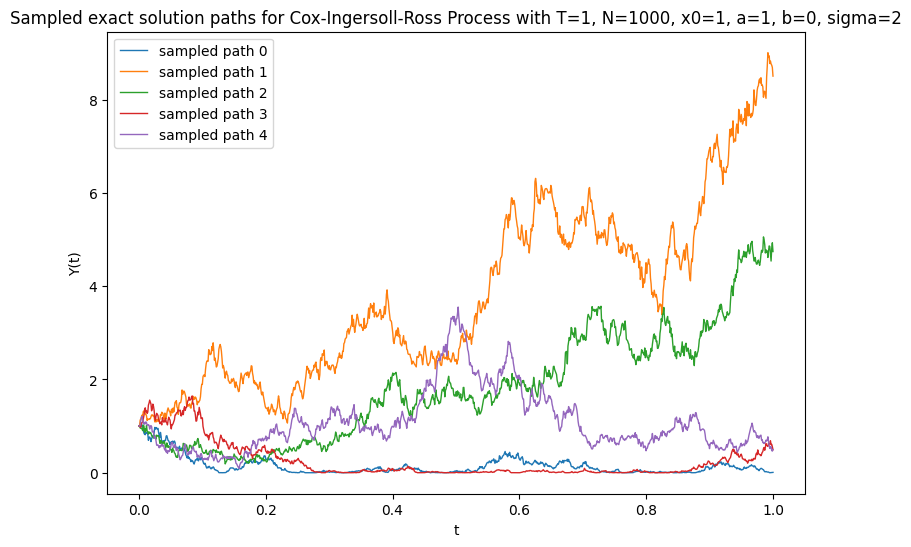

In [8]:
simulations = 5
exact_solutions = sde.exact_solutions(simulations)

for num in range(simulations):
    exact_solution = exact_solutions[:, num]
    plt.plot(sde.ts, exact_solution, label = "sampled path " + str(num))

plt.title(f'Sampled exact solution paths for {sde}')
plt.ylabel('Y(t)')
plt.xlabel('t')
plt.legend()

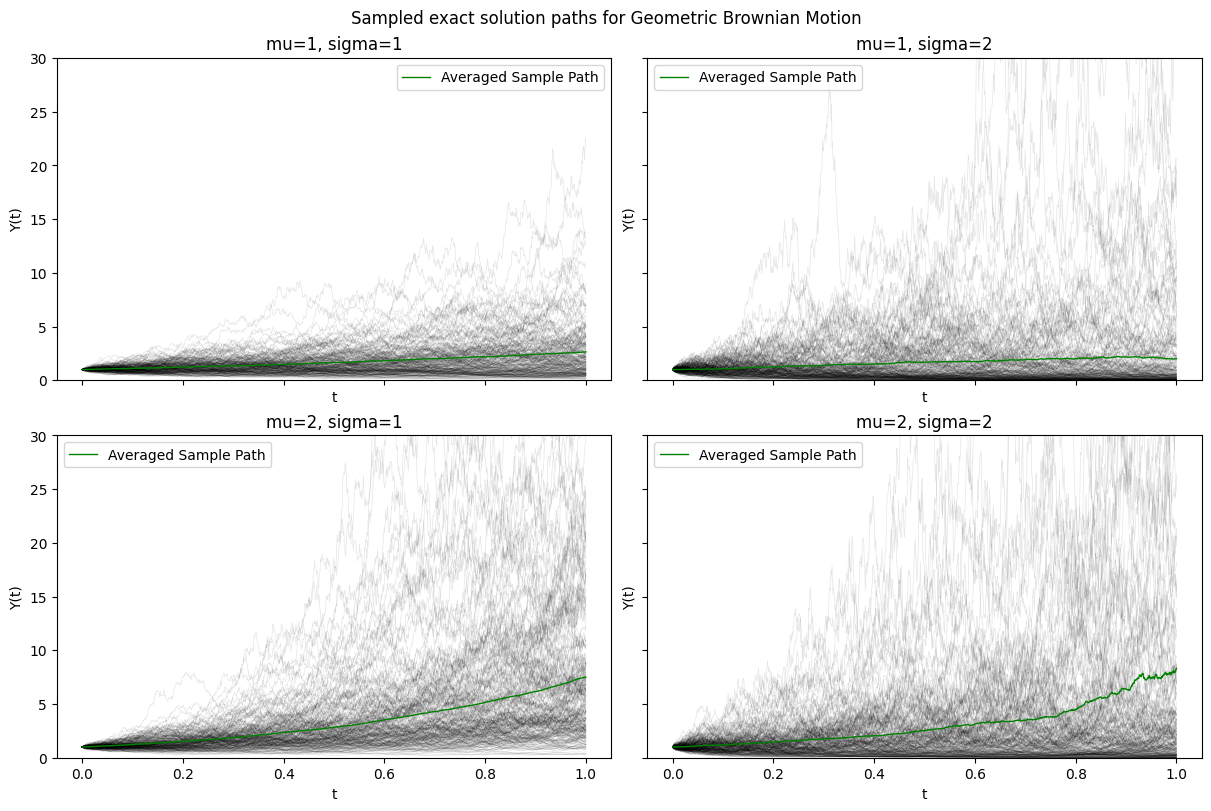

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), constrained_layout=True, sharex=True, sharey=True)
fig.suptitle('Sampled exact solution paths for Geometric Brownian Motion')


# Simulate sample paths
simulations = 1000
num_plots = 250
ylim = 30 

# Exact Solutions for different parameters
mus = [1, 2]
sigmas = [1, 2]
for i in range(len(mus)):
    for j in range(len(sigmas)):
        gbm = GeometricBrownianMotion(time_horizon=T, num_steps=1000, x0=X0, mu=mus[i], sigma=sigmas[j])
        exact_solutions = gbm.exact_solutions(num_simulations=simulations)
        for k in range(num_plots):
            axs[i, j].plot(gbm.ts, exact_solutions[:, k], alpha=0.1, color='black', linewidth=0.5)
        axs[i, j].plot(gbm.ts, np.mean(exact_solutions, axis=1), label="Averaged Sample Path", color='green')
        axs[i, j].set_title(f'mu={mus[i]}, sigma={sigmas[j]}')
        axs[i, j].set_ylabel('Y(t)')
        axs[i, j].set_xlabel('t')
        axs[i, j].set_ylim(0, ylim)
        axs[i, j].legend()

## Solution approximations

In [10]:
APPROXIMATION_METHODS = ['Euler-Maruyama', 'Milstein', 'Runge-Kutta']

def euler_maruyama(sde: SDE, num_simulations=1, seed=None):
    W = sde.sample_brownian_motion(num_simulations, seed)
    dW = np.diff(W, axis=0)
    X = np.zeros((sde.N, num_simulations))
    X[0] = sde.x0
    for i in range(sde.N - 1):
        X[i+1] = X[i] + sde.drift(X[i], sde.ts[i]) * sde.dt + sde.diffusion(X[i], sde.ts[i]) * dW[i]
    return X.squeeze()

def milstein(sde: SDE, num_simulations=1, seed=None):
    assert all(sde.diffusion(sde.x0, 0) == sde.diffusion(sde.x0, t) for t in sde.ts), "Milstein method requires diffusion to be independent of time"
    
    # symbolic differentiation of diffusion function
    x = Symbol('X')
    if hasattr(sde, 'diffusion_derivative'):
        diffusion_derivative = sde.diffusion_derivative
    else:
        diffusion_derivative = lambdify(x, diff(sde.diffusion(x, t=0), x), 'numpy')
    
    W = sde.sample_brownian_motion(num_simulations, seed)
    dW = np.diff(W, axis=0)
    X = np.zeros((sde.N, num_simulations))
    X[0] = sde.x0
    for i in range(sde.N - 1):
        X[i+1] = (X[i] + sde.drift(X[i], sde.ts[i]) * sde.dt + sde.diffusion(X[i], sde.ts[i]) * dW[i]
                + 0.5 * sde.diffusion(X[i], sde.ts[i]) * diffusion_derivative(X[i]) * (dW[i] ** 2 - sde.dt))
    return X.squeeze()

def runge_kutta(sde: SDE, num_simulations=1, seed=None):
    assert all(sde.drift(sde.x0, 0) == sde.drift(sde.x0, t) for t in sde.ts), "Runge-Kutta method requires drift to be independent of time"
    assert all(sde.diffusion(sde.x0, 0) == sde.diffusion(sde.x0, t) for t in sde.ts), "Runge-Kutta method requires diffusion to be independent of time"
    
    W = sde.sample_brownian_motion(num_simulations, seed)
    dW = np.diff(W, axis=0)
    X = np.zeros((sde.N, num_simulations))
    X[0] = sde.x0
    for i in range(0, sde.N-1):
        a = sde.drift(X[i], 0)
        b = sde.diffusion(X[i], 0)
        korr_X = X[i] + a * sde.dt + b * sde.dt ** 0.5
        X[i+1] = X[i] + a * sde.dt + b * dW[i] + 0.5 * (sde.diffusion(korr_X, 0) - b) * (dW[i] ** 2 - sde.dt) * (sde.dt ** -0.5)
    return X.squeeze()

def approximation_method(name: str):
    if name == 'Euler-Maruyama':
        return euler_maruyama
    elif name == 'Milstein':
        return milstein
    elif name == 'Runge-Kutta':
        return runge_kutta
    else:
        raise NotImplementedError(f'Approximation method {name} not implemented')

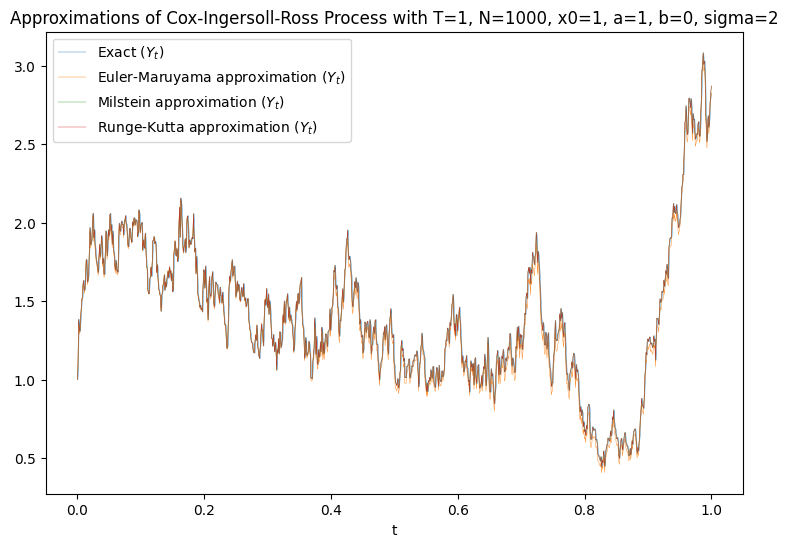

In [11]:
plt.title(f'Approximations of {sde}')

# Exact Solution
if hasattr(sde, 'exact_solutions'):
    exact_solution = sde.exact_solutions(num_simulations=1, seed=SEED)
    plt.plot(sde.ts, exact_solution, label="Exact ($Y_t$)", linewidth=0.3)
for method_name in APPROXIMATION_METHODS:
    approximation = approximation_method(method_name)(sde, num_simulations=1, seed=SEED)
    plt.plot(sde.ts, approximation, label=f"{method_name} approximation ($Y_t$)", linewidth=0.3)
plt.xlabel('t')
plt.legend()

## Convregence rates

In [12]:
def calculate_error(solutions, calc_approximations, p=1, strong=True):
    assert p >= 1, "p \in [1, \infty)"
    if strong:
        error = np.max(np.mean(np.abs(solutions - calc_approximations) ** p, axis=1) ** (1/p))
    else:
        error = np.max(np.abs(np.mean(solutions, axis=1) ** p - np.mean(calc_approximations, axis=1) ** p) ** (1/p))
    return error

In [16]:
%%time

# Initiate dt grid and lists to store errors
strong_errors = {method_name: [] for method_name in APPROXIMATION_METHODS}  # TODO: L^p errors
weak_errors = {method_name: [] for method_name in APPROXIMATION_METHODS}
dt_grid = [10 ** R for R in (-3, -2, -1)]
num_steps_grid = [int(sde.T / dt) for dt in dt_grid]
simulations = 10000

print(f'SDE is {sde}')
for N in num_steps_grid:
    print(f"Running simulations for N = {N}")
    # Initiate SDE
    sde.update_time_discretization(num_steps=N)
    
    # Generate many sample paths
    exact_solutions = sde.exact_solutions(num_simulations=simulations, seed=SEED)
    approximations = {
        method_name: approximation_method(method_name)(sde, simulations, seed=SEED)
        for method_name in APPROXIMATION_METHODS
    }
    
    # Strong errors
    for method_name in APPROXIMATION_METHODS:
        strong_errors[method_name].append(
            calculate_error(exact_solutions, approximations[method_name], p=1, strong=True)
        )
    # Weak errors
    for method_name in APPROXIMATION_METHODS:
        weak_errors[method_name].append(
            calculate_error(exact_solutions, approximations[method_name], p=1, strong=False)
        )
print("Done.")

SDE is Cox-Ingersoll-Ross Process with T=1, N=1000, x0=1, a=1, b=0, sigma=2
Running simulations for N = 1000
Running simulations for N = 100
Running simulations for N = 10
Done.
CPU times: user 13 s, sys: 3.87 s, total: 16.8 s
Wall time: 16.8 s


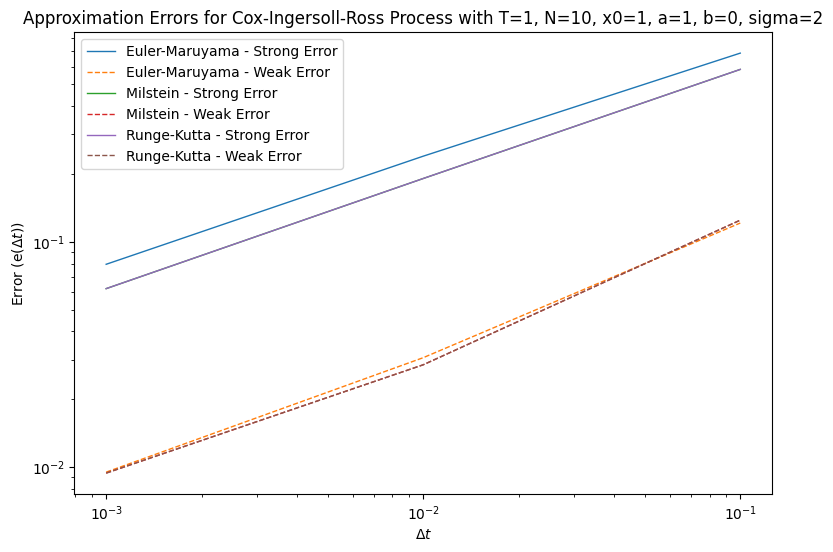

In [17]:
# Plot
delta_ts = dt_grid
for method_name in APPROXIMATION_METHODS:
    plt.loglog(delta_ts, strong_errors[method_name], label=f"{method_name} - Strong Error")
    plt.loglog(delta_ts, weak_errors[method_name], label=f"{method_name} - Weak Error", ls='--')
plt.title(f'Approximation Errors for {sde}')
plt.xlabel('$\Delta t$')
plt.ylabel('Error (e($\Delta t$))')
plt.legend()

In [18]:
def calculate_convergence_rate(errors, dts):
    # TODO: should it be upper bound instead of best fitting linear model?
    x = np.log(dts).reshape(-1, 1)
    y = np.log(errors)
    reg = LinearRegression().fit(x, y)
    return reg.coef_.item()

In [ ]:
adapted_sde_name = str(sde).replace(f"N={sde.N}", f"N in {num_steps_grid}")
print(f'SDE: {sde}')
print("---")
for method_name in APPROXIMATION_METHODS:
    strong_covnergence_rate = calculate_convergence_rate(strong_errors[method_name], delta_ts)
    print(f"Strong {method_name} Convergence: {strong_covnergence_rate}")
    weak_convergence_rate = calculate_convergence_rate(weak_errors[method_name], delta_ts)
    print(f"Weak {method_name} Convergence: {weak_convergence_rate}")
    print("---")